# Task 2: Logistic Regression

Notes: for the features of the model, instead of using the average embedding vector betqeen query and passage, you could do:
1) Cosine similarity between query vector and passage vector
2) BM25 score between query and passage
3) Length of query
4) Length of passage


## Imports and Installs

In [1]:
from nltk.stem import WordNetLemmatizer
import contractions
import string
import pickle
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [2]:
!pip install bcolz-zipline

In [3]:
import bcolz

## Text normalisation function

In [4]:
def normalise(text):
    '''
    Function that normalises text and returns tokens.
    Input: text --> text string we want to tokenise
    Output: tokens --> list of tokens taken from the text string
    '''

    text = text.lower() # convert all to lower case
    text = contractions.fix(text) # expand contractions
    text = text.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation))) # remove punctuation
    tokens = text.split() # tokenisation
    filtered_tokens = [w for w in tokens if not w in stop_words] # remove stop words
    # filtered_tokens = list(map(lemmatizer.lemmatize, filtered_tokens)) # lemmatization of nouns

    return filtered_tokens

## Data manipulation
- Define a way to transform words into word embeddings --> GloVe
- For the data frames of training and validation, replace the text in the actual query and passage cells with word embeddings. For every work in the sentence, we calculate the word embedding with GloVe and then we average the embeddings between all the words in the sentence to get the global sentence embedding. Note that we do not need to worry about padding due to different sentence lengths, because all the word embeddings are vectors of length 50, so the resulting average will also be a vector of length 50, so all the model input data will have the same size.

Working with GloVe...
- We remove capitalisation and contractions
- Should we remove punctuation? It is necessary when the query is actually about the use of some type of punctuation, but this is very unlikely, and it will make it messier in predictions, sow e will remove punctuation
- Should we remove top words? Yes, since they do not add meaning of the query to the actual passage, and so for example if a passager has many stop words, and only 2 important words, and then the original query has the 2 important words but no stop words, maybe the model will attribute the passage to a query that also includes many stop words, which would be wrong. Better to eliminate stop words.
- GloVe includes all words, so no need to lemmatize? No, no need to lemmatize.
- The main problem I see here is with composite words that use punctuation in between. GloVe has them in their vocabulary, but they are hard to tokenise, excluding punctuation but then making exceptions for these kind of words, i.e. 'ar' and 'ar-15'. So for now we will ignore this pitfall, work by removing all punctuation, and see what the performance of the model is like.

### 1) Load training and validation dataframes

In [5]:
train_dataframe = pd.read_csv('train_data.tsv', delimiter='\t')
val_dataframe = pd.read_csv('validation_data.tsv', delimiter='\t')

### 2) Set up word embeddings with GloVe

In [6]:
#Load in pickled embeddings
vectors = bcolz.open('6B.50.dat')[:]
words = pickle.load(open('6B.50_words.pkl', 'rb'))
word2idx = pickle.load(open('6B.50_idx.pkl', 'rb'))
glove = {w: vectors[word2idx[w]] for w in words}

### 3) Perform normalisation and word embeddings --> prepare input data for logistic regression model
- Remember some words in your corpus might not be in GloVe, so you need to replace them by $<unk>$ token.
- The query/passage embeddings are calculated as the average of the tokens in the query/passage.
- We could 1) concatenate query/passage embeddings, 2) make an average embedding, or 3) compute cosine similarity between centroid of query and passage embeddings.
- We tested all 3 options, and we use option 2 since it is the one that yielded the best results.


In [7]:
X_data_train = []
y_data_train = []

def train_data_extraction(row):

    q_embed = np.zeros(50) # we chose glove vectors to have length = 50
    p_embed = np.zeros(50)
    
    query = normalise(row['queries'])
    for q in query:
        try:
            q_embed += glove[q]
        except:
            q_embed += glove['<unk>'] # if the token is not present in GloVe, we assign it as <unk>
    q_embed /= len(query)

    passage = normalise(row['passage'])
    for p in passage:
        try:
            p_embed += glove[p]
        except:
            p_embed += glove['<unk>'] # if the token is not present in GloVe, we assign it as <unk>
    p_embed /= len(passage)

    rel = row['relevancy']
    
    # x = np.concatenate((q_embed,p_embed)) # concatenate query and passage embedding
    x = (q_embed + p_embed) / 2 # average of query and passage embedding
    X_data_train.append(x)
    y_data_train.append(rel)

_ = train_dataframe.apply(lambda row: train_data_extraction(row), axis=1)

X_data_train = np.array(X_data_train)
y_data_train = np.array(y_data_train)

In [8]:
# np.savetxt('processed_X_train_data.txt', X_data_train, fmt='%f')
# np.savetxt('processed_y_train_data.txt', y_data_train, fmt='%f')

In [9]:
X_data_val = []
y_data_val = []

def val_data_extraction(row):

    q_embed = np.zeros(50) # we chose glove vectors to have length = 50
    p_embed = np.zeros(50)
    
    query = normalise(row['queries'])
    for q in query:
        try:
            q_embed += glove[q]
        except:
            q_embed += glove['<unk>'] # if the token is not present in GloVe, we assign it as <unk>
    q_embed /= len(query)

    passage = normalise(row['passage'])
    for p in passage:
        try:
            p_embed += glove[p]
        except:
            p_embed += glove['<unk>'] # if the token is not present in GloVe, we assign it as <unk>
    p_embed /= len(passage)

    rel = row['relevancy']
    
    # x = np.concatenate((q_embed,p_embed)) # concatenate query and passage embedding
    x = (q_embed + p_embed) / 2 # average of query and passage embedding
    X_data_val.append(x)
    y_data_val.append(rel)

_ = val_dataframe.apply(lambda row: val_data_extraction(row), axis=1)

X_data_val = np.array(X_data_val)
y_data_val = np.array(y_data_val)

In [10]:
# np.savetxt('processed_X_val_data.txt', X_data_val, fmt='%f')
# np.savetxt('processed_y_val_data.txt', y_data_val, fmt='%f')

## Logistic Regression Model

### 1) Prepare input data
Input data already prepared in previous section. 
- We have X data in numpy array of size (n,d) where n = number of (qid,pid) combinations, and d = number of concatednated features = 50 (the input is the average of the query and passage embedding).
- The resulting X matrix is a matrix of query and passage embeddings, concatenated.
- The resulting y matrix contains the n relevancies of the n (qid,pid) pairs in matrix X. It is a vector of length n.

### 2) Model

In [11]:
def gradient_descent ( z, loss_func, grad_func, lr=0.01,
                       loss_stop=1e-4, z_stop=1e-4, max_iter=100 ):
    """
    Generic batch gradient descent optimisation.
    Iteratively updates z by subtracting lr * grad
    until one or more stopping criteria are met.
    
    # Arguments
        z: initial value(s) of the optimisation var(s).
            can be a scalar if optimising a univariate
            function, otherwise a single numpy array
        loss_func: function of z that we seek to minimise,
            should return a scalar value
        grad_func: function calculating the gradient of
            loss_func at z. for vector z, this should return
            a vector of the same length containing the
            partial derivatives
        lr: learning rate, ie fraction of the gradient by 
            which to update z each iteration
        loss_stop: stop iterating if the loss changes
            by less than this (absolute)
        z_stop: stop iterating if z changes by less than
            this (L2 norm)
        max_iter: stop iterating after iterating this
            many times
    
    # Returns
        zs: a list of the z values at each iteration
        losses: a list of the losses at each iteration
    """
    losses = [ loss_func(z) ]
    zs = [ z ]
    
    d_loss = np.inf
    d_z = np.inf

    while (len(losses) <= max_iter) and (d_loss > loss_stop) and (d_z > z_stop):
        zs.append(zs[-1] - lr * grad_func(zs[-1]))
        losses.append(loss_func(zs[-1]))
        
        d_loss = np.abs(losses[-2] - losses[-1])
        d_z = np.linalg.norm(zs[-2] - zs[-1])
    
    return zs[1:], losses[1:]

In [12]:
# auxiliary functions
def add_x0(X):
    """
    Prepend a column (or array) of 1s to an array of samples,
    as a dummy feature representing bias/offset/intercept.
    
    # Arguments
        X: a table or array of variable values, where the last dimension
           indexes the variables
    
    # Returns:
        X: the table or array with all records prefixed with a constant
           term x0
    """
    x0 = np.expand_dims(np.ones(X.shape[:-1], X.dtype), axis=-1)
    return np.concatenate((x0, X), axis=-1)

def reshaped_apply(X, func):
    """
    Apply a function to a data array. 

    If X has more than 2 dimensions, all but the last are unwound into
    matrix rows, and then the results vector y is rewound back into the
    original shape of those dimensions. The main use case for this is
    to work with grids generated by `make_grid`.    

    # Arguments
        X: a table or array of variable values, where the last dimension
           indexes the values
        func: a function taking a single 2d array argument and returning
           a vector
    
    # Returns
        y: a vector or array of function outputs for the features in X,
           and having a corresponding shape
    """
    rewind = None
    if len(X.shape) > 2:
        rewind = X.shape[:-1]
        X = X.reshape(np.product(rewind), X.shape[-1])
    
    y = func(X)
    
    if rewind is not None:
        y = y.reshape(rewind)
    
    return y

def affine(X, weights):
    """
    Generic affine function of X computed as X . [weights]^T
    
    If the weights vector is 1 longer than the number of features in X, we
    assume it incudes a bias term in first position, and prepend a
    corresponding x0 (=1) to X before multiplying.

    If X has more than 2 dimensions, all but the last are unwound into
    matrix rows, and then the results vector y is rewound back into the
    original shape of those dimensions. The main use case for this is
    to work with grids generated by `make_grid`.    
    
    # Arguments
        X: a table or array of variable values, where the last dimension
           indexes the values
        weights: a vector of coefficients, either the same length as the last
           dimension of X, or 1 longer
    
    # Returns
        y: a vector or array of dot products of the input observations
           with the weights
    """
    if len(weights) == (X.shape[-1] + 1):
        X = add_x0(X)
    
    return reshaped_apply(X, lambda z: z @ weights)

def sigmoid ( z ):
    return 1/(1 + np.exp(-z))

def logistic_forward ( X, w ):
    return sigmoid(affine(X, w))

def logistic_loss ( X, y, w, eps=1e-10 ):
    g = logistic_forward(X, w)
    return (np.dot(-y, np.log(g + eps)) - np.dot((1 - y), np.log(1 - g + eps)))/len(y)

def logistic_grad ( X, y, w ):
    g = logistic_forward(X, w)
    return X.T @ (g - y)

In [13]:
def logistic_regression ( X, y, w0=None, lr=0.05,
                          loss_stop=1e-4, weight_stop=1e-4, max_iter=100 ):
    """
    Fit a logistic regression classifier to data.
    
    # Arguments
        X: an array of sample data, where rows are samples
           and columns are features. caller is responsible
           for prepending x0=1 terms if required.
        y: vector of binary class labels for the samples,
           must be same length as number of rows in X
        w0: starting value of the weights, if omitted
           then all zeros are used
        lr: learning rate, ie fraction of gradients by
           which to update weights at each iteration
        loss_stop: stop iterating if the loss changes
            by less than this (absolute)
        weight_stop: stop iterating if weights change by less
            than this (L2 norm)
        max_iter: stop iterating after iterating this
            many times
           
    # Returns
        ws: a list of fitted weights at each iteration
        losses: a list of the loss values at each iteration
    """
    assert(len(X.shape)==2)
    assert(X.shape[0]==len(y))
    
    if w0 is None: w0 = np.zeros(X.shape[-1])
    
    return gradient_descent ( w0,
                              loss_func = lambda z: logistic_loss(X, y, z),
                              grad_func = lambda z: logistic_grad(X, y, z),
                              lr = lr,
                              loss_stop=loss_stop, z_stop=weight_stop, max_iter=max_iter )

### 3) Training
- Here we make a function for training that also takes the learning rate as a variable, and keeps track of the loss during training. So that later on we can analyse the effect of the learning rate on the model training loss. Note that the training loss will be Binary Cross-Entropy.
- Here we obtain a weight matrix w, which we will use in the validation to make predictions, and then compare them to the actual relevancies to analyse the performance of the model.
- Note that the logistic regression function returns a list of the fitted weights at each iteration. We are only interested in the weights at the last iteration.

In [14]:
ws, losses = logistic_regression(X_data_train, y_data_train, lr=0.01)
best_w = ws[-1]

<ipython-input-12-0ff16e4942a2>:78: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-z))


### 4) Validation
Here we rank the validation data (passages for each query) using the trained model

In [15]:
y_pred_val =  logistic_forward(X_data_val, best_w)

<ipython-input-12-0ff16e4942a2>:78: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-z))


In [16]:
# Now we need to make a ranking for each query with the results from y_pred_val
# Get the (qid,pid) pairs from the validation set, and also the unique qid

unique_qids = val_dataframe['qid'].copy()
unique_qids = unique_qids.drop_duplicates()
unique_qids = unique_qids.reset_index(drop=True)
unique_qids = np.array(unique_qids) # vector of unique qid in the validation set

qid_pid_val = val_dataframe[['qid','pid']].copy()
qid_pid_val = np.array(qid_pid_val) # (n,2) array, where each row corresponds to the (qid, pid) pair of each sample

In [17]:
LR_scores = pd.DataFrame(columns=['qid', 'A', 'pid', 'rank', 'score', 'algoname']) # dataframe where we store global results for all queries

for qid in unique_qids:
    output_info = pd.DataFrame(columns=['qid', 'A', 'pid', 'rank', 'score', 'algoname']) # dataframe where we store 
                                                                                         # the results for the current query
    qid_pairs = qid_pid_val[qid_pid_val[:,0] == qid]
    qid_rels = y_pred_val[qid_pid_val[:,0] == qid]
    indxs = np.argsort(qid_rels)[::-1]
    sorted_qid_pairs = qid_pairs[indxs]
    sorted_qid_rels = qid_rels[indxs]
    
    # Now we just get the top 100 scores (if they are available)
    top_sorted_qid_pairs = sorted_qid_pairs[:100,:]
    top_sorted_qid_rels = sorted_qid_rels[:100]

    # Prepare the array with 'A2'
    A2 = np.array(['A2'] * len(top_sorted_qid_rels))

    # Prepare the array with the ranks
    rank = np.array(range(1,len(top_sorted_qid_rels)+1))

    # Prepare the array with the algonamme 'LR'
    algoname = np.array(['LR'] * len(top_sorted_qid_rels))

    # Put everything together in the output_info dataframe
    output_info['qid'] = top_sorted_qid_pairs[:,0]
    output_info['A'] = A2
    output_info['pid'] = top_sorted_qid_pairs[:,1]
    output_info['rank'] = rank
    output_info['score'] = top_sorted_qid_rels
    output_info['algoname'] = algoname

    # Append this query dataframe to the one with global results
    LR_scores = LR_scores.append(output_info, ignore_index=True)

In [18]:
# Example of how to check results
# LR_scores[LR_scores['qid'] == unique_qids[990]]
# LR_scores[LR_scores['score'] == 1]

In [19]:
# Save ranking file as LR.txt
np.savetxt(r'LR.txt', LR_scores.values, fmt=['%d','%s','%d','%d','%f','%s'])

### 5) Assess performance of model on validation data
For this part we use the mAP and NDCG functions defiend in Task 1

In [20]:
# Set up dataframes for the functions
tq = val_dataframe[['qid', 'queries']].copy()
tq = tq.drop_duplicates()
tq = tq.reset_index(drop=True)

relevancies = val_dataframe[['qid', 'pid', 'relevancy']].copy()

In [21]:
# Load ranking data created in previous part
LR_ranking = pd.read_csv('LR.txt', delimiter=' ', header=None, names=['qid', 'A', 'pid', 'rank', 'score', 'algoname'])
ranking = LR_ranking[['qid', 'pid', 'score']].copy()

Now copy the AP and NDCG functions from Task 1

In [22]:
# mAP function
def AP(queries, ranking, relevancies, k):
    '''
    Function that computes the Average Precision (AP) metric for each query in 'queries', based on a ranking determined by 
    a retrieval model, where queries are matched with passages from most relevant to least relevant, and based on relevancies 
    between queries and passages.

    Inputs:
    queries = data frame of queries for which you want to calculate the AP metric (contains qid and actual query)
    ranking = data frame of queries and passages pairs, where higher score pairs are ranked higher (for each query)
    relevancies = data frame of relevancies between each possible (qid,pid) pair
    k = top k passages you want to take into account when calculating the AP metric

    Outputs:
    APs = list of AP@k metric for each query, in the same order of appearance as the input list 'queries'
    mAP = mean Average Precision of all the queries
    '''

    APs = []

    for q in queries['qid']:
        AP_values = []
        cum_rel = 0 # cumulative number of relevant passages found in the ranking

        max_k = len(ranking[ranking['qid'] == q])
        iter = min(k,max_k) # This is because we some queries do not have that many candidate passages

        for i in range(1,iter+1):
            p = int(ranking[ranking['qid'] == q].reset_index(drop=True).iloc[i-1]['pid'])
            relevancy = relevancies[(relevancies['qid'] == q) & (relevancies['pid'] == p)]['relevancy'].values.item()
            if relevancy != 0: # we operate when we encounter a relevant passage
                cum_rel += relevancy
                AP_values.append(cum_rel / i) 

        if len(AP_values) != 0:    
            APs.append(sum(AP_values)/len(AP_values))
        else: # we do this to avoid the computing error of dividing 0/0
            APs.append(0)

    mAP = np.mean(APs)

    return APs, mAP

In [23]:
# NDCG function
def NDCG(queries, ranking, relevancies, k):
    '''
    Function that computes the Normalized Discounted Cumulative Gain (NDCG) metric for each query in 'queries', 
    based on a ranking determined by a retrieval model, where queries are matched with passages from most relevant 
    to least relevant, and based on relevancies between queries and passages.

    Inputs:
    queries = data frame of queries for which you want to calculate the AP metric (contains qid and actual query)
    ranking = data frame of queries and passages pairs, where higher score pairs are ranked higher (for each query)
    relevancies = data frame of relevancies between each possible (qid,pid) pair
    k = top k passages you want to take into account when calculating the AP metric

    Outputs:
    NDCGs = list of AP@k metric for each query, in the same order of appearance as the input list 'queries'
    mNDCG = mean Average Precision of all the queries
    '''

    NDCGs = []

    for q in queries['qid']:
        DCG = 0
        IDCG = 0

        max_k = len(ranking[ranking['qid'] == q])
        iter = min(k,max_k) # This is because we some queries do not have that many candidate passages

        # Get the relevancies for the ideal ranking (of the top k candidates??? - doesn't matter for our data tho), in order
        sorted_revs = relevancies[relevancies['qid'] == q].sort_values(by=['relevancy'], ascending=False)['relevancy'].values

        for i in range(1,iter+1):
            IDCG += (2**sorted_revs[i-1] - 1)/np.log2(i+1)

            p = int(ranking[ranking['qid'] == q].reset_index(drop=True).iloc[i-1]['pid'])
            rel = relevancies[(relevancies['qid'] == q) & (relevancies['pid'] == p)]['relevancy'].values.item()
            DCG += (2**rel - 1)/np.log2(i+1)

        if IDCG != 0:
            NDCGs.append(DCG/IDCG)
        else: # we do this to avoid the computing error of dividing 0/0
            NDCGs.append(0)

    mNDCG = np.mean(NDCGs)

    return NDCGs, mNDCG

Compute the preformance metrics

In [24]:
AP_3, mAP_3 = AP(tq, ranking, relevancies, 3)
AP_10, mAP_10 = AP(tq, ranking, relevancies, 10)
AP_100, mAP_100 = AP(tq, ranking, relevancies, 100)

NDCG_3, mNDCG_3 = NDCG(tq, ranking, relevancies, 3)
NDCG_10, mNDCG_10 = NDCG(tq, ranking, relevancies, 10)
NDCG_100, mNDCG_100 = NDCG(tq, ranking, relevancies, 100)

In [25]:
print(mAP_3, mAP_10, mAP_100)

print(mNDCG_3, mNDCG_10, mNDCG_100)

0.0030487804878048786 0.005420399867263979 0.008302550194078372
0.0036579815828371963 0.008514783474616615 0.024729627517578595


### 6) Analyse the effect of the learning rate on the model training loss
For this we use the 'train' function defined earlier

In [26]:
lrs = [0.5,0.1,0.05,0.01,0.001]
loss = []
its = []

for l_r in lrs:
    _, losses = logistic_regression(X_data_train, y_data_train, lr=l_r, loss_stop=1e-5, weight_stop=1e-5)
    loss.append(losses)
    its.append(len(losses))

<ipython-input-12-0ff16e4942a2>:78: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-z))


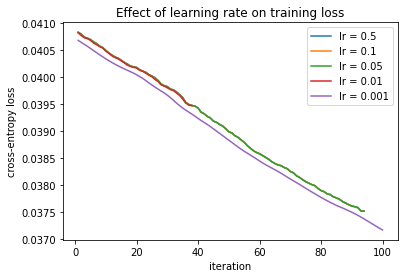

<Figure size 432x288 with 0 Axes>

In [27]:
for i in range(5):
    plt.plot(range(1,its[i]+1), loss[i], label=f'lr = {lrs[i]}')
plt.xlabel('iteration')
plt.ylabel('cross-entropy loss')
plt.title('Effect of learning rate on training loss')
plt.legend()
plt.show()
plt.savefig('learning_rate.png')

## End of Task 2